In [1]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-10-07

Goals: 
Fit the data

Each Section can/should run independently,
only these initial imports should be shared among all sections

Questions:
What determines memory limit of the workers
How to partition the dataframe in order to get more workers active


"""
import numpy as np
import pandas as pd
import pyarrow as pa

# from scipy.spatial import KDTree
import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper


from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
import dask
# many workers
# dask.config.set(scheduler='threads') 

# does not work
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(20))

# one worker
# dask.config.set(scheduler='processes')  
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
# cluster.adapt(minimum=10, maximum=40) 

In [3]:
ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 64,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33749,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:46814,Total threads: 8
Dashboard: http://127.0.0.1:42191/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:40032,


In [4]:
# Tape Single Pixel - real data 

# Tape Single Pixel - real data 

In [4]:
# if running on baldur
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=False,
                 sort=False,
                 )

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/core.py:5243: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/core.py:5243: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [5]:
def med_mag(mag):
    mag_no_nan = mag[~np.isnan(mag)]
    return np.median(mag_no_nan)

In [6]:
ens.query("band_ztf_source == 'g'", table = 'source')
ens.prune(10)
#med_mag_res = ens.batch(med_mag, ens._flux_col, compute=False)
#ens.assign(g_med_mag = med_mag_res)
#ens.query("g_med_mag < 20", table = 'object')
ens.query("rMeanPSFMag_ps1_otmo < 20", table = 'object')

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

Temporary columns dropped from Object Table: ['nobs_total']


/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [10]:
ens._object.compute()['']

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,yMeanPSFMag_ps1_otmo,yMeanPSFMagErr_ps1_otmo,yFlags_ps1_otmo,Norder_ps1_otmo,Dir_ps1_otmo,Npix_ps1_otmo,_DIST,Norder,Dir,nobs_total
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
024341.05-010243.3,4996749735944519680,4240,55455,178,40.921044,-1.045386,4240-55455-0178,BOSS,2.369000,VI,...,19.193501,0.039844,115000,5,0,4438,0.000016,5,0,252
024234.93-010351.9,4996754941277110272,6782,56572,334,40.645567,-1.064436,6782-56572-0334,BOSS,1.373000,VI,...,19.281900,0.050055,115000,5,0,4438,0.000004,5,0,241
024347.34-005354.9,4996771631947841536,3651,55247,294,40.947287,-0.898595,3651-55247-0294,BOSS,0.237000,VI,...,18.469999,0.044246,16892216,5,0,4438,0.000009,5,0,279
024347.11-004949.3,4996775603542687744,6782,56572,297,40.946311,-0.830385,6782-56572-0297,BOSS,0.565000,VI,...,19.084700,0.032752,115000,5,0,4438,0.000015,5,0,45
024425.39-004653.0,4996818172750331904,6782,56602,218,41.105805,-0.781410,6782-56602-0218,BOSS,0.936000,VI,...,18.399401,0.061579,115000,5,0,4438,0.000013,5,0,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
024419.10+005539.2,4997824956667527168,6782,56572,772,41.079588,0.927557,6782-56572-0772,BOSS,0.821000,VI,...,19.677601,0.056099,115000,5,0,4438,0.000017,5,0,346
024221.87+004912.7,4997837085797777408,9381,57758,79,40.591144,0.820204,9381-57758-0079,BOSS,2.060000,VI,...,17.924200,0.020761,115000,5,0,4438,0.000016,5,0,370
024200.53+005322.2,4997845805743210496,6782,56572,610,40.502233,0.889509,6782-56572-0610,BOSS,0.964000,VI,...,18.615900,0.030714,115000,5,0,4438,0.000010,5,0,657


In [11]:
ens_nobs = ens.calc_nobs(temporary=False)

In [12]:
len(ens_nobs._object['nobs_total'].compute().values)

127

(17.0, 21.0)

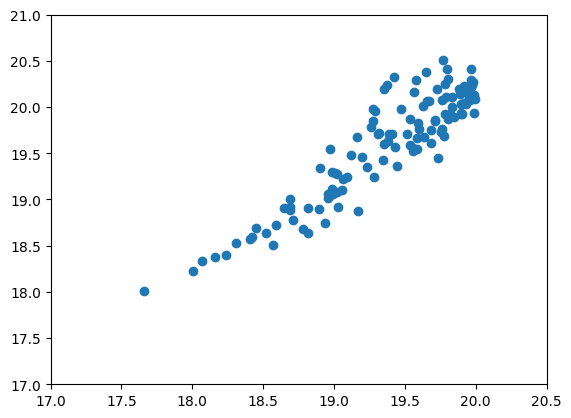

In [15]:
plt.scatter(ens._object['rMeanPSFMag_ps1_otmo'].compute().values, ens._object['gMeanPSFMag_ps1_otmo'].compute().values)
plt.xlim(17,20.5)
plt.ylim(17,21)

(17.0, 23.0)

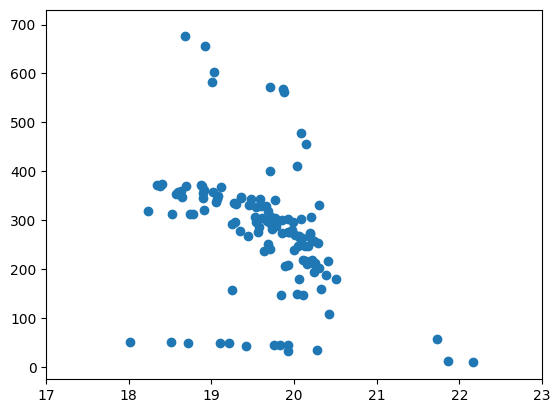

In [16]:
plt.scatter( ens._object['gMeanPSFMag_ps1_otmo'].compute().values,ens_nobs._object['nobs_total'].compute().values)
plt.xlim(17,23)

(array([ 4.,  9.,  4.,  0.,  1.,  0.,  2.,  3.,  3.,  4.,  7.,  6.,  8.,
        13., 14.,  7., 17.,  7.,  6.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  2.,  2.,  1.,  0.,  0.,  1.,  1.,  1.]),
 array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190., 210.,
        230., 250., 270., 290., 310., 330., 350., 370., 390., 410., 430.,
        450., 470., 490., 510., 530., 550., 570., 590., 610., 630., 650.,
        670., 690., 710.]),
 <BarContainer object of 35 artists>)

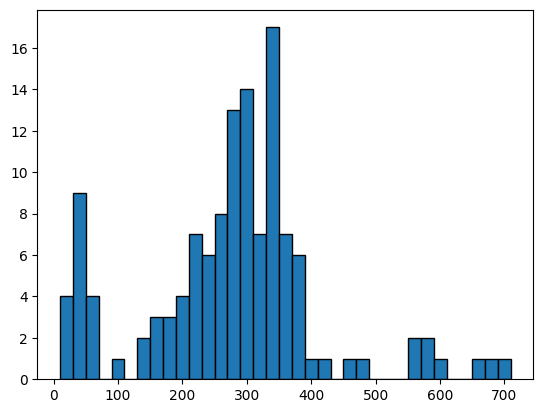

In [19]:

data = ens_nobs._object['nobs_total'].compute().values

bin_edges = range(min(data), max(data) + 21, 20) 
plt.hist(data, bins=bin_edges, edgecolor='k')  # 'k' sets black color for edges


In [6]:
# ens._source = ens._source.repartition(npartitions = 40)

In [20]:
# 9min, 13 sec on baldur, for 603 sources in 4 partitions
# 7min, 30 sec on baldur, for 603 sources in 4 partitions, Nov 7
# 5min, 14 sec on baldur, for 603 sources in 10 partitions, Nov 7

# 3min, 3 sec on baldur, with padding 
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [9]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

In [57]:
df = pd.DataFrame(columns = ['neg_log_lh','log_drw_scale', 'log_drw_amp', 'log_per_scale', 'log_per_amp'],
                   index = res_tsp.index)
for i in range(len(res_tsp)):
    df.iloc[i] = res_tsp[i]

pa_table = pa.Table.from_pandas(df)
pa.parquet.write_table(pa_table, "/astro/users/ncaplar/data/res_tsp_run_g_0.parquet")

/tmp/ipykernel_86669/1838388558.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.iloc[i] = res_tsp[i]


In [58]:
df_drw = pd.DataFrame(columns = ['neg_log_lh', 'log_drw_scale', 'log_drw_amp'],
                   index = res_tsp_drw.index)

for i in range(len(res_tsp_drw)):
    df_drw.iloc[i] = res_tsp_drw[i]
    
pa_table_drw = pa.Table.from_pandas(df_drw)
pa.parquet.write_table(pa_table_drw, "/astro/users/ncaplar/data/res_tsp_run_g_0_drw.parquet")

/tmp/ipykernel_86669/1680990878.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_drw.iloc[i] = res_tsp_drw[i]
